In [1]:
import numpy as np
import iapws
from iapws import IAPWS97 as gas

In [2]:
MPa = 10 ** 6
kPa = 10 ** 3
unit = 1 / MPa
to_kelvin = lambda x: x + 273.15 if x else None

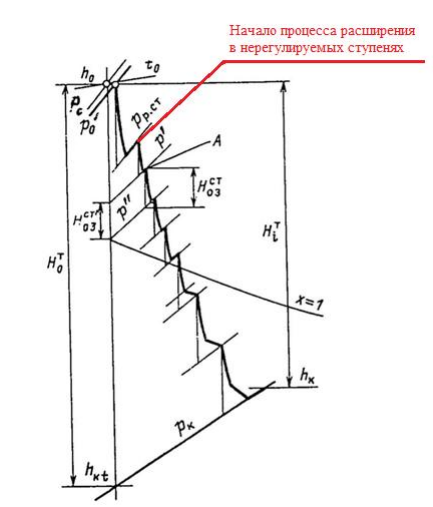

### Начальные параметры

In [3]:
speed_stage_diam = 1.1
rotation_speed = 50
n_stages = 10
mass_flow = 239.275 

p0 = 18.05 * MPa
h0 = 3276.79 # kJ/kg
pz = 3.74 * MPa


# Techincal params
delta_diam = 0.2
speed_coefficient = 0.93
alpha_1 = 14
root_reaction_degree = 0.05
discharge_coefficient = 0.96
overlapping = 0.003
efficiency = 0.88

### Разбивка по ступеням теплоперепада

In [4]:
avg_diam_1 = speed_stage_diam - delta_diam

point_0 = gas(P=p0 * unit, h=h0)

In [5]:
veernost_1 = 37

In [6]:
def get_reaction_degree(root_dor, veernost):
    return root_dor + (1.8 / (veernost + 1.8))

def get_u_cf(dor):
    cos = np.cos(np.deg2rad(alpha_1))
    return speed_coefficient * cos / (2 * (1 - dor) ** 0.5)

def get_heat_drop(diameter, u_cf):
    first = (diameter / u_cf) ** 2
    second = (rotation_speed / 50) ** 2
    return 12.3 * first * second

In [7]:
avg_reaction_degree_1 = get_reaction_degree(root_reaction_degree, veernost_1)
u_cf_1 = get_u_cf(avg_reaction_degree_1)
heat_drop_1 = get_heat_drop(avg_diam_1, u_cf_1)

In [8]:
h1 = point_0.h - heat_drop_1
point_2 = gas(h=h1, s=point_0.s)

In [9]:
upper = mass_flow * point_2.v * u_cf_1
lower = discharge_coefficient * np.sin(np.deg2rad(alpha_1)) * rotation_speed * (np.pi * avg_diam_1) ** 2 * (1 - avg_reaction_degree_1) ** 0.5

blade_length_1 = upper / lower
blade_length_2 = blade_length_1 + overlapping

In [10]:
assert np.isclose(avg_diam_1 / blade_length_1, veernost_1, rtol=0.01)

In [11]:
root_diameter = avg_diam_1 - blade_length_2

In [12]:
point_zt = gas(P=pz * unit, s=point_0.s)
full_heat_drop = h0 - point_zt.h
actual_heat_drop = full_heat_drop * efficiency
hz = h0 - actual_heat_drop
point_z = gas(P=pz * unit, h=hz)

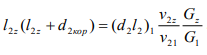

In [13]:
# assume linearity in term of volume distribution

from scipy.optimize import fsolve

def equation_to_solve(x):
    return x ** 2 + x * root_diameter - avg_diam_1 * blade_length_2 * point_z.v / point_2.v

In [14]:
blade_length_z = fsolve(equation_to_solve, 0.01)[0]
blade_length_z

0.08239641989760703

In [15]:
avg_diam_2 = root_diameter + blade_length_z
avg_diam_2

0.955066864944328

Предполагаем, что средний диаметр ступеней и высота лопаток изменяются вдоль
ЦВД линейно. Тогда можно построить диаграммы их изменения  для
цилиндра с количеством ступеней (Z). Таким образом из графиков или по формуле, для
каждой ступени имеем величину среднего диаметра и высоты рабочей лопатки;

In [16]:
def linear_distribution(left, right, x):
    return (right - left) * x + left

In [17]:
x = np.cumsum(np.ones(n_stages) * 1 / (n_stages - 1)) - 1 / (n_stages - 1)

In [18]:
diameters = linear_distribution(avg_diam_1, avg_diam_2 , x)

blade_lengths = linear_distribution(blade_length_2, blade_length_z , x)

veernosts = diameters / blade_lengths

reaction_degrees = get_reaction_degree(root_dor=root_reaction_degree, veernost=veernosts)

u_cf = get_u_cf(dor=reaction_degrees)

heat_drops = get_heat_drop(diameters, u_cf)

output_speed_coeff_loss = np.full_like(heat_drops, 0.95)
output_speed_coeff_loss[0] = 1

actual_heat_drops = output_speed_coeff_loss * heat_drops

In [19]:
mean_heat_drop = np.mean(actual_heat_drops)
mean_heat_drop

42.40968783847866

In [20]:
actual_heat_drops

array([43.95783632, 41.83584452, 41.9196596 , 42.01105097, 42.1097027 ,
       42.21531976, 42.32762633, 42.4463643 , 42.57129182, 42.70218206])

In [21]:
reheat_factor = 4.8 * 10 ** (-4) * (1 - efficiency) * full_heat_drop * (n_stages - 1) / n_stages
reheat_factor

0.020970356876377088

In [22]:
full_heat_drop * (1 + reheat_factor) / mean_heat_drop
# По правилам округления, округляется в 10. Т.е. совпадает с начальным предположением

9.73842862570894

In [23]:
bias = full_heat_drop * (1 + reheat_factor) - np.sum(actual_heat_drops)
bias = bias / n_stages
bias

-1.109316033116579

In [24]:
new_actual_heat_drop = actual_heat_drops + bias
new_actual_heat_drop

array([42.84852029, 40.72652849, 40.81034356, 40.90173494, 41.00038667,
       41.10600372, 41.2183103 , 41.33704827, 41.46197579, 41.59286603])

In [25]:
import matplotlib.pyplot as plt

def plot_distribution(values, ax_name):
    fig, ax = plt.subplots(1, 1, figsize=(15,5))
    ax.plot(range(1, 11), values,  marker='o')
    ax.set_xlabel("Номер ступени")
    ax.set_ylabel(ax_name)
    ax.grid()

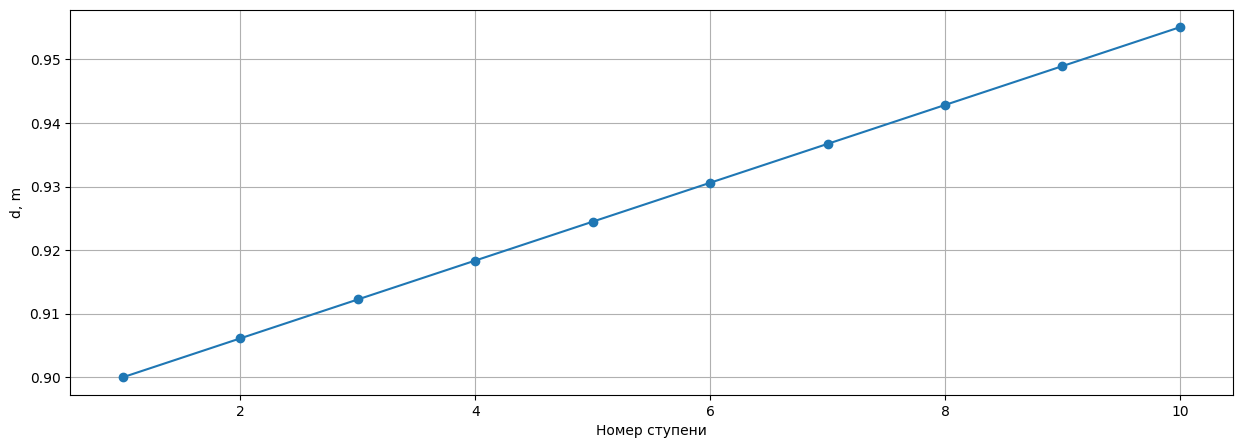

In [26]:
plot_distribution(diameters, "d, m")

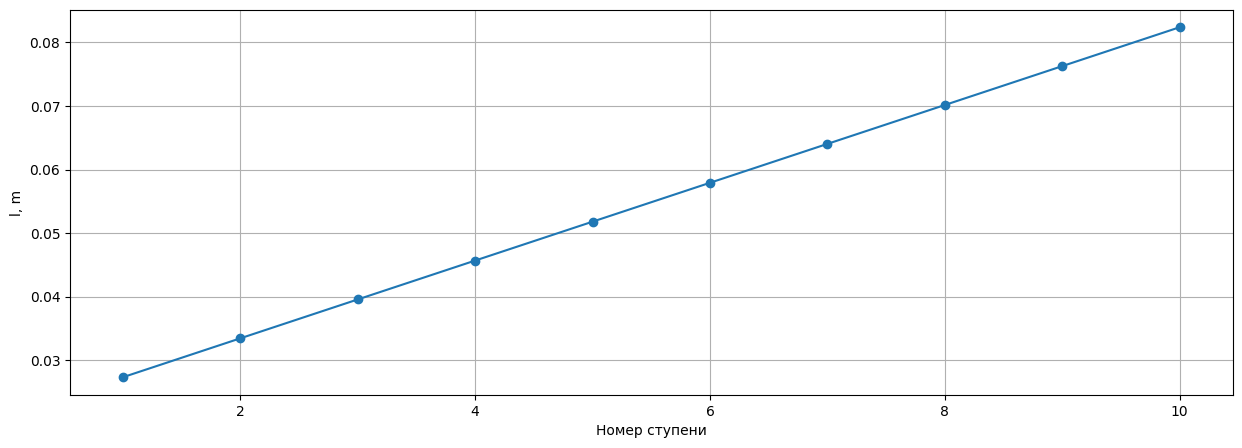

In [27]:
plot_distribution(blade_lengths, "l, m")

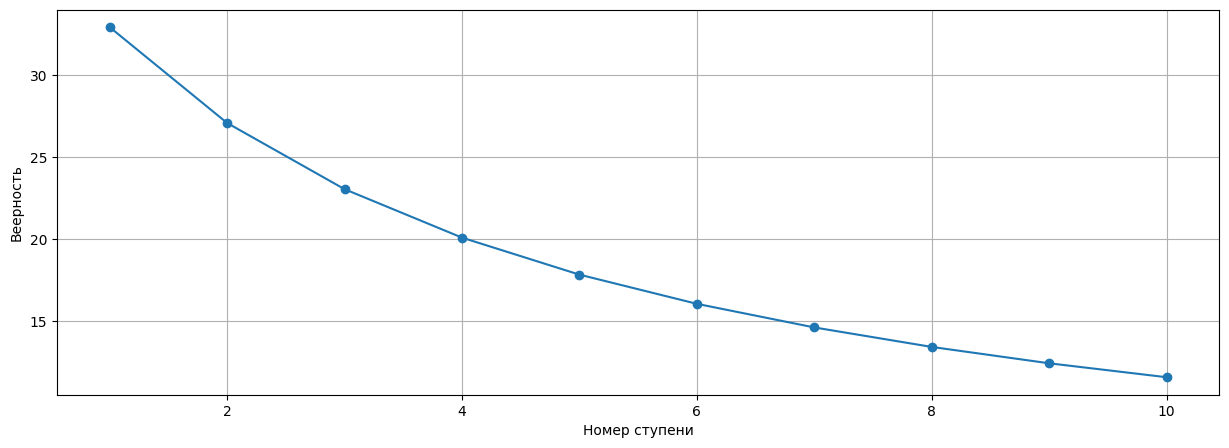

In [28]:
plot_distribution(veernosts, "Веерность")

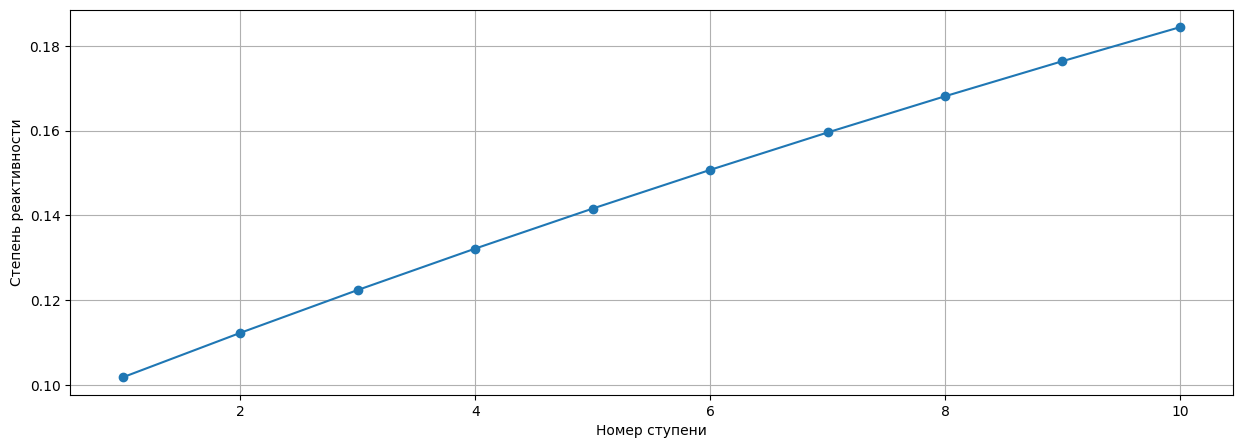

In [29]:
plot_distribution(reaction_degrees, "Степень реактивности")

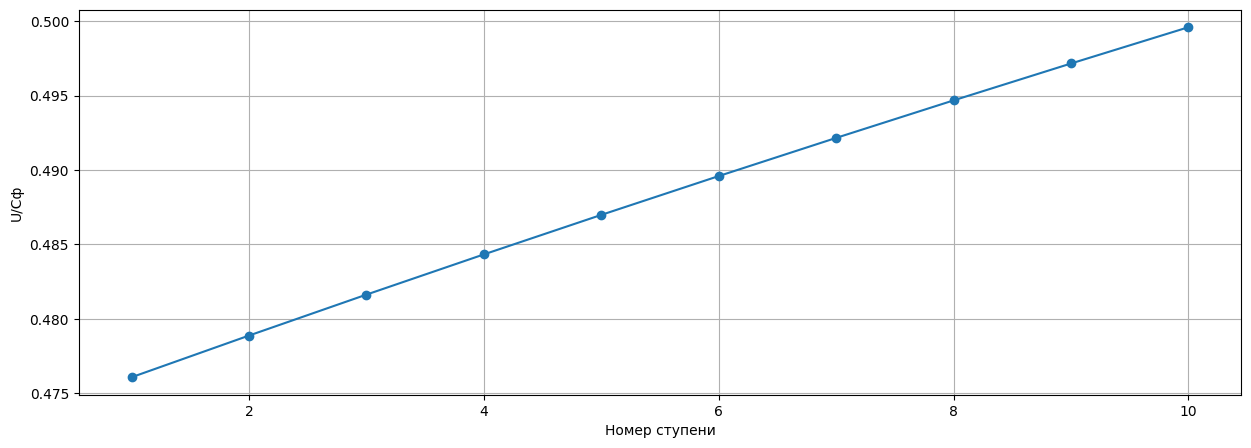

In [30]:
plot_distribution(u_cf, "U/Cф")

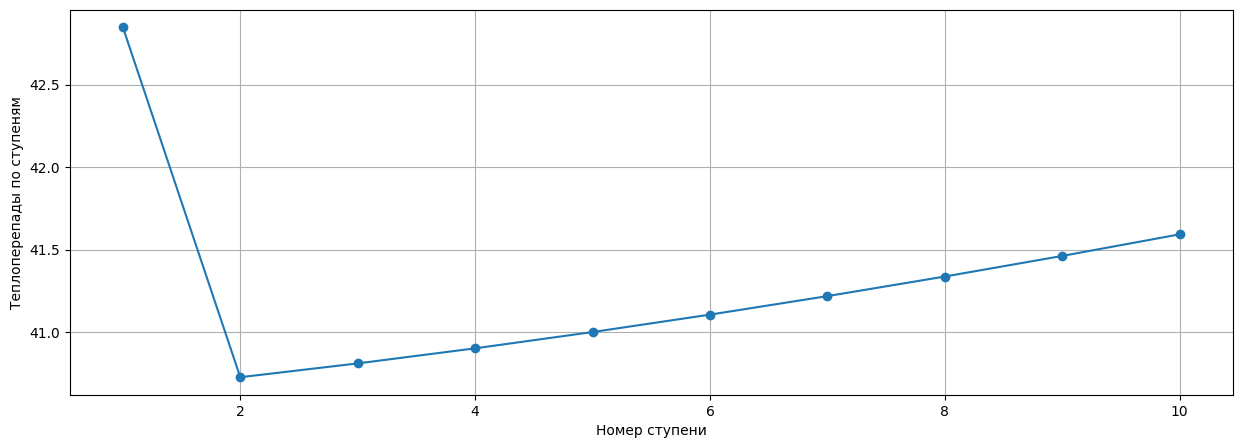

In [31]:
plot_distribution(new_actual_heat_drop, "Теплоперепады по ступеням")